In [2]:
import os
# from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import datetime
# import pandas as pd
import xarray as xr
from scipy import signal

In [3]:
# fileLocation = '/Users/tennismichel/Coding/Python/DLR_LIDAR/Data'
fileLocation = '../../v8combined'
# fileName = "20190612-2040_T15Z900.nc"
fileName = "20180118-0253_T15Z900.nc"
path = os.path.join(fileLocation, fileName)

In [5]:
DS = xr.open_dataset(path, decode_times=False)
# attrs = {'units': 'seconds since 2019-10-15 00:00:00'}
# ds = xr.Dataset({'time': ('time', DS.time, attrs)})
DS.time.values = DS.time.values / 1000
DS.integration_start_time.values = DS.integration_start_time.values / 1000
DS.integration_end_time.values = DS.integration_end_time.values / 1000

# Decode the time offset
unit_str = DS.time_offset.attrs['units']
unit_str = unit_str[14:-6]

time_reference = datetime.datetime.strptime(unit_str, '%Y-%m-%d %H:%M:%S.%f')
time_offset = datetime.timedelta(seconds=float(DS.time_offset.values[0]))
new_time_reference = time_reference + time_offset
time_reference_str = datetime.datetime.strftime(new_time_reference, '%Y-%m-%d %H:%M:%S')

DS.time.attrs['units'] = 'seconds since ' + time_reference_str
DS.integration_start_time.attrs['units'] = 'seconds since ' + time_reference_str
DS.integration_end_time.attrs['units'] = 'seconds since ' + time_reference_str

DS = xr.decode_cf(DS, decode_coords = True, decode_times = True) 

# date for plotting should always refer to the center of the plot (04:00 UTC)
start_date = datetime.datetime.utcfromtimestamp(DS.time.values[0].astype('O')/1e9)
ten_pm_date = datetime.datetime(start_date.year, start_date.month, start_date.day, 22, 0,0)
if start_date.hour > 18:
    DS['date_startp'] = ten_pm_date
    DS['date_endp'] = ten_pm_date + datetime.timedelta(hours=12)
else:
    DS['date_startp'] = ten_pm_date - datetime.timedelta(hours=24)
    DS['date_endp'] = ten_pm_date - datetime.timedelta(hours=12)

## Altitude ## 
DS['alt_plot'] = DS.altitude/1000 + DS.altitude_offset + DS.station_height #km

## Temperature ## 
# Change 0 to NaN
DS.temperature.values = np.where(DS.temperature == 0, np.nan, DS.temperature)
# date = datetime.datetime.strptime(DS.date_data_start, '%b %d %H:%M:%S %Y')
DS.station_height

<xarray.DataArray 'station_height' (value: 1)>
array([0], dtype=uint32)
Dimensions without coordinates: value
Attributes:
    units:      meter
    long_name:  height above WGS84

In [6]:
DS.altitude_offset

<xarray.DataArray 'altitude_offset' (value: 1)>
array([0], dtype=uint32)
Dimensions without coordinates: value
Attributes:
    units:      meter
    long_name:  station height above WGS84

/Users/tennismichel/anaconda3/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/Users/tennismichel/anaconda3/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


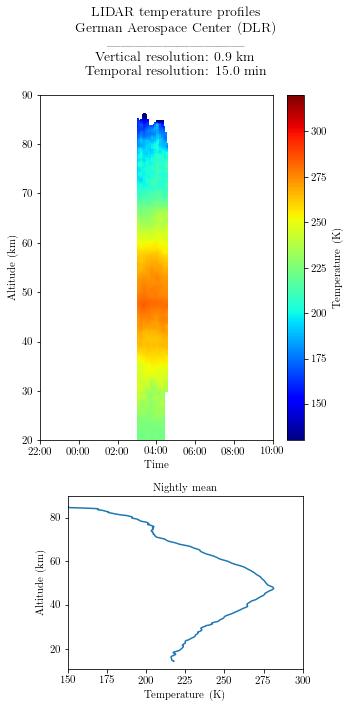

In [4]:
### PLOT ###
use_tex = 1 
if use_tex:
    ### Set tex font
    plt.rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
    plt.rc('text', usetex=True)

    # Set font size
    SMALL_SIZE = 10.95
    MEDIUM_SIZE = 10.95
    plt.rc('font', size=MEDIUM_SIZE)         # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title
    ###

# matplotlib.rcParams['font.sans-serif'] = "Comic Sans MS"
# plt.rcParams['font.family'] = "sans-serif"
fig, (ax0, ax1) = plt.subplots(nrows=2, figsize=(5,10), gridspec_kw={'height_ratios': [2, 1]})
# im = ax0.pcolormesh(x, y, z, cmap=cmap, norm=norm)
im_temp = ax0.pcolormesh(DS.time, DS.alt_plot, np.matrix.transpose(DS.temperature.values),
                         cmap='jet', vmin=130, vmax=320)
ax0.set_ylim(20,90)

# Labels
cbar = fig.colorbar(im_temp, ax=ax0)
cbar.set_label('Temperature (K)')
ax0.set_xlabel('Time')
ax0.set_ylabel('Altitude (km)')

# X-Ticks
# if day > daybefore show date in new line
h_fmt = mdates.DateFormatter('%H:%M')
h_interv = mdates.HourLocator(interval = 2)
ax0.xaxis.set_major_locator(h_interv)
ax0.xaxis.set_major_formatter(h_fmt)
ax0.set_xlim(DS.date_startp.values,DS.date_endp.values)

# tempMean = np.where(tempMean == 0, np.nan, tempMean)

## Mean Plot (altitude vs. temperature)
ax1.plot(DS.temperature.mean(axis=0), DS.alt_plot)
ax1.set_xlim(150,300)
ax1.set_aspect('1.4')

# Labels 
ax1.set_title('Nightly mean')
ax1.set_xlabel('Temperature (K)')
ax1.set_ylabel('Altitude (km)')

fig.suptitle('LIDAR temperature profiles\n \
German Aerospace Center (DLR) \n \
------------------------------ \n \
Vertical resolution: {} km\n \
Temporal resolution: {} min'.format(DS.altitude.resolution / 1000, DS.time.resolution / (1000*60)), fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.88]) # tuple (left, bottom, right, top),
# annotate() for fixed ratios